Running simulations for Strongly skewed...
Running simulations for Moderately skewed...
Running simulations for Mildly skewed...
Running simulations for Long-tailed...
Running simulations for Short-tailed...


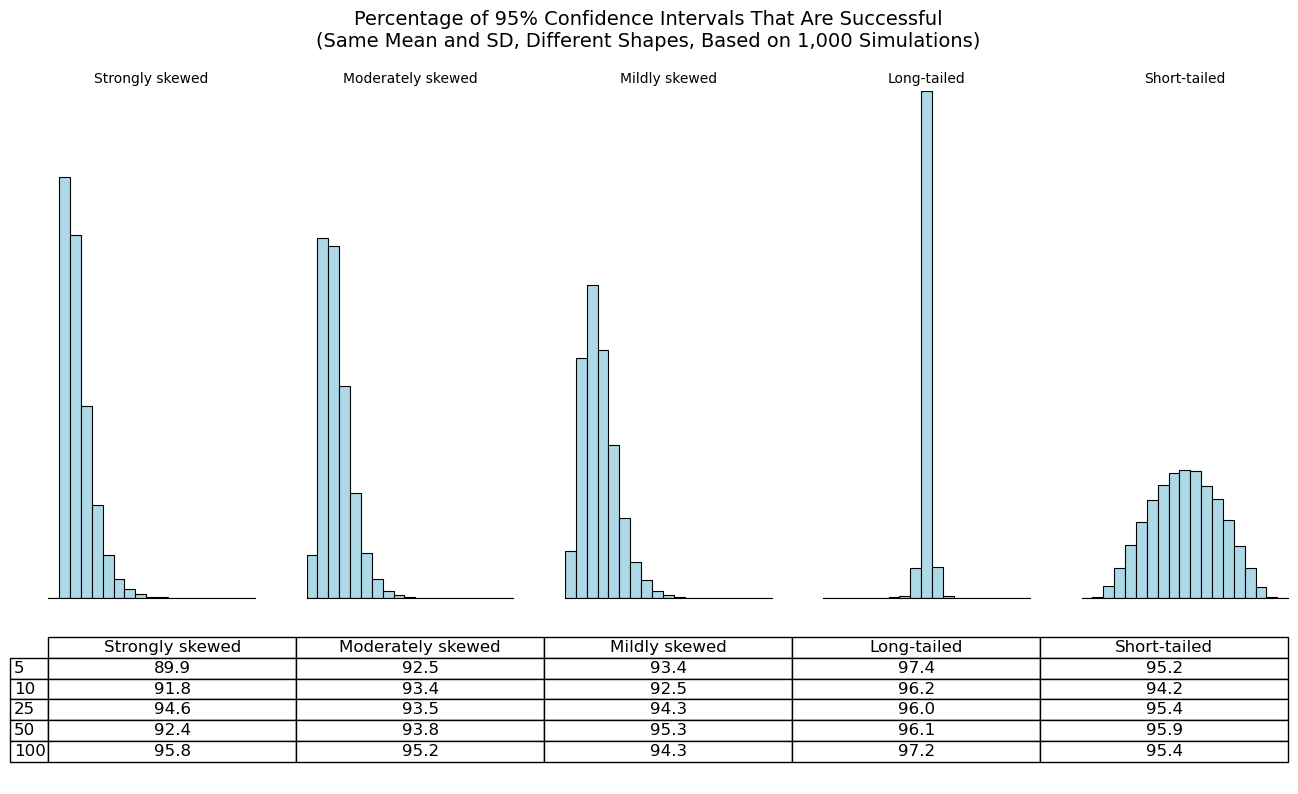

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2, t, beta
from scipy import stats
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

# --- Set seed and sample size ---
np.random.seed(1)
n_viz = 50000
sample_sizes = [5, 10, 25, 50, 100]
n_simulations = 1000
true_mean = 0.0

# --- Define standardized distribution generators ---
distribution_generators = {
    "Strongly skewed": lambda n: (chi2.rvs(df=3, size=n) - 3) / np.sqrt(6),
    "Moderately skewed": lambda n: (chi2.rvs(df=5, size=n) - 5) / np.sqrt(10),
    "Mildly skewed": lambda n: (chi2.rvs(df=8, size=n) - 8) / np.sqrt(16),
    "Long-tailed": lambda n: t.rvs(df=2.5, size=n) / np.sqrt(2.5 / (2.5 - 2)),
    "Short-tailed": lambda n: ((beta.rvs(a=3, b=3, size=n) - 0.5) * 2) / 0.37796
}

# --- CI Simulation using generator-based sampling ---
def run_ci_simulations(dist_func, true_mean, sample_sizes, n_simulations=1000):
    results = {}
    for n in sample_sizes:
        count = 0
        for _ in range(n_simulations):
            sample = dist_func(n)
            mean = np.mean(sample)
            se = np.std(sample, ddof=1) / np.sqrt(n)
            t_crit = stats.t.ppf(0.975, df=n - 1)
            lower = mean - t_crit * se
            upper = mean + t_crit * se
            if lower <= true_mean <= upper:
                count += 1
        results[n] = round(100 * count / n_simulations, 1)
    return results

# --- Run simulations ---
ci_results = {}
for name, generator in distribution_generators.items():
    print(f"Running simulations for {name}...")
    ci_results[name] = run_ci_simulations(generator, true_mean, sample_sizes, n_simulations)

ci_df = pd.DataFrame(ci_results, index=sample_sizes)
ci_df.index.name = "Sample size"

# --- Histogram binning setup ---
bin_edges = {
    "Strongly skewed": np.linspace(-2, 12, 20),
    "Moderately skewed": np.linspace(-2, 12, 20),
    "Mildly skewed": np.linspace(-2, 10, 20),
    "Long-tailed": np.linspace(-20, 20, 20),
    "Short-tailed": np.linspace(-3, 3, 20)
}
distributions_viz = {name: gen(n_viz) for name, gen in distribution_generators.items()}

# --- Compute y-axis scaling ---
bin_heights = {}
for name, data in distributions_viz.items():
    counts, _ = np.histogram(data, bins=bin_edges[name])
    bin_heights[name] = counts.max()
global_max = max(bin_heights.values())
scaled_max = int(global_max * 0.5)  # 50% for all but long-tailed

# --- Create combined figure ---
fig = plt.figure(figsize=(16, 9), constrained_layout=False)
gs = GridSpec(2, 1, height_ratios=[3, 1], hspace=0.05)

# --- Top row: histograms ---
gs_top = GridSpecFromSubplotSpec(1, 5, subplot_spec=gs[0], wspace=0.25)
for i, (name, data) in enumerate(distributions_viz.items()):
    ax = fig.add_subplot(gs_top[0, i])
    ax.hist(data, bins=bin_edges[name], color="lightblue", edgecolor="black", linewidth=0.8, density=False)
    ax.set_title(name, fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim(0, global_max if name == "Long-tailed" else scaled_max)
    ax.set_xlim(bin_edges[name][0], bin_edges[name][-1])
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)
    ax.spines['bottom'].set_visible(True)

# --- Bottom row: CI success rate table ---
ax_table = fig.add_subplot(gs[1])
ax_table.axis("off")
table_data = ci_df.round(1).astype(str)
table = ax_table.table(cellText=table_data.values,
                       rowLabels=table_data.index,
                       colLabels=table_data.columns,
                       cellLoc='center',
                       loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.25)

# --- Title ---
fig.suptitle(
    "Percentage of 95% Confidence Intervals That Are Successful\n"
    "(Same Mean and SD, Different Shapes, Based on 1,000 Simulations)",
    fontsize=14, y=0.97
)

# --- Save to PNG ---
plt.savefig("ci_simulation_combined_scaled_histograms.png", dpi=300, bbox_inches='tight')
plt.show()
